In [1]:
#!/usr/bin/env python3
#coding=utf-8
import time
from Arm_Lib import Arm_Device
import numpy as np
import ikpy.chain

import argparse
import os
import platform
import shutil
import time
from pathlib import Path

import pyrealsense2 as rs
import numpy as np
import cv2

import torch
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import (
    check_img_size, non_max_suppression, apply_classifier, scale_coords, 
    xyxy2xywh, plot_one_box, strip_optimizer, set_logging)
from utils.torch_utils import select_device, load_classifier, time_synchronized
from matplotlib import pyplot as plt

SERVO_SPEED = 3.5
LINK_LIST = [0,30,83,83,80,90]
TOMATO_SIZE = (0.033, 0.037)  # (单位：米)

GRABBER = {
    'open':80,
    'close':160,
}
DROP_POSITION = [-0.05,-0.2,0.15]

def read_servolines(Arm):
    angle = []
    time.sleep(0.02)
    for i in range(6):
        aa = Arm.Arm_serial_servo_read(i+1)
        if aa:
            angle.append(aa)
        else:
            angle.append(0)
        time.sleep(.002)
    time.sleep(.002)
    return angle
    


def servo_write(Arm,angle,servo_speed,s_time=None):
    calculate_time = calculate_servotime(Arm,angle,servo_speed)
    # s_time = 1500
    if s_time:
        Arm.Arm_serial_servo_write6(angle[0], angle[1], angle[2], angle[3], angle[4], angle[5], s_time)
        time.sleep(s_time/1000)
        return s_time
    else:
        Arm.Arm_serial_servo_write6(angle[0], angle[1], angle[2], angle[3], angle[4], angle[5], calculate_time)
        time.sleep(calculate_time/1000)
        return calculate_time
    

def calculate_servotime(Arm,target,servo_speed=3):
    servotime = np.array(read_servolines(Arm))-np.array(target)
    return int(max(max(np.abs(servotime)) *servo_speed*5,500))

def one_step(model,pipeline,align,names,img_save=True):
    
    frames = pipeline.wait_for_frames()
    aligned_frames = align.process(frames)
    aligned_depth_frame = aligned_frames.get_depth_frame()
    color_frame = aligned_frames.get_color_frame()
    # 将帧转换为numpy数组
    color_image = np.asanyarray(color_frame.get_data())
    color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
    depth_intrinsics = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
    device = select_device('')
    # path, img, im0s, vid_cap = LoadStreams(source, img_size=320)
    
    img = torch.tensor(color_image)
    img = np.transpose(img, (2, 0, 1))
    half = device.type != 'cpu'  # half precision only supported on CUDA
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    
    img = img.to(device)
    t1 = time_synchronized()
    pred = model(img, augment=True)[0]

    # Apply NMS
    pred = non_max_suppression(pred, 0.8, 0.3, classes=None, agnostic=True)
    t2 = time_synchronized()

    # Process detections
    img = np.array(img.squeeze(0).cpu())
    img = np.transpose(img, (1, 2, 0))
    img = img * 255
    img = img.astype(np.uint8)
    for i, det in enumerate(pred):  # detections per image
        # Print time (inference + NMS)
        print('Done. ({:.3f}s)'.format((t2 - t1)))    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if det is not None:
        for *xyxy, conf, cls in reversed(det):
            label = '%s %.2f' % (names[int(cls)], conf)
            print(xyxy)
            plot_one_box(xyxy, img, label=label, line_thickness=3)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.show()
    if img_save:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite("a.png",img)
    return det,aligned_depth_frame,depth_intrinsics



def camera_to_world(P_cam, T_cam, R_cam):
    """
    将相机坐标系下的点转换为世界坐标系。
    
    参数：
        P_cam (numpy.array): 相机坐标系下的点 (3x1)。
        T_cam (numpy.array): 相机在世界坐标系中的位置 (3x1)。
        R_cam (numpy.array): 相机的旋转矩阵 (3x3)。
    
    返回：
        numpy.array: 世界坐标系下的点 (3x1)。
    """
    P_world = R_cam @ P_cam + T_cam
    return P_world

def calculate_frame_coor(det):
    res = []
    for i,(*xyxy, conf, cls) in enumerate(det):
        # 现在只抓番茄
        if cls == 1:
            x = int(xyxy[2]-xyxy[0])
            y = int(xyxy[3]-xyxy[1])
            c_x = int((xyxy[0]+ xyxy[2])/2)
            c_y = int((xyxy[1]+ xyxy[3])/2)
            res.append([i,c_x,c_y,x,y,conf,cls])
    return res

def select_tomato():
    # 根据坐标计算得分并选择番茄,现在是用得分最高的
    # 可以用最靠近一侧的番茄
    pass

def control_arm_coor(Arm,my_chain,target_position,grabber,rotation=90,compensate=2):
    converted_position = np.array(target_position)
    print("target coor:",converted_position)
    joints = my_chain.inverse_kinematics(converted_position,initial_position = np.radians([0,90,120,30,40,90,30]))
    joint_list = joints[1:-2]
    print("servos should be",np.degrees(joint_list))
    joint_deg_list = [int(x)for x in np.degrees(joint_list)]
    joint_deg_list.append(rotation)
    joint_deg_list.append(grabber)
    print("The angles of each joints should be:" , joint_deg_list)
    real_frame = my_chain.forward_kinematics(joints)
    error = np.abs(np.linalg.norm(list(real_frame[:3,3]),ord=2)-np.linalg.norm(converted_position,ord=2))
    print("Error:{:.2f}%".format(error*100))
    print("The position is:\n", real_frame)
    if "{:.2f}%".format(error*0.05) != "0.00%":
        print("out of range")
    else:
        print(joint_deg_list)
        if compensate & all([(x - compensate) < 179 for x in joint_deg_list[1:4]]):
            
            joint_deg_list[1:4] = [(x+compensate) for x in joint_deg_list[1:4]]
            print(f"final joint:{joint_deg_list}")
        return servo_write(Arm,joint_deg_list,SERVO_SPEED),joint_deg_list


def object_axis_angle(xyxy,depth_image, padding=5):
    obj_depth_image = depth_image[(xyxy[1]-padding):(xyxy[3]+padding),(xyxy[0]-padding):(xyxy[2]+padding)]
    hist, bin_edges = np.histogram(obj_depth_image,120,range=(100,600))

    min_val = bin_edges[np.argmax(hist)-2]
    max_val = bin_edges[np.argmax(hist)+2]

    mask = (obj_depth_image > min_val) & (obj_depth_image < max_val)
    # 找到 mask 中为 True 的坐标
    y_coords, x_coords = np.where(mask)
    points = np.column_stack((x_coords, y_coords))  # 转换为点集

    # 计算旋转最小包围矩形
    rect = cv2.minAreaRect(points.astype(np.float32))  # (center, (width, height), angle)

    # 提取矩形参数
    (center_x, center_y), (width, height), angle = rect

    # 短轴的倾斜角计算
    if width < height:
        short_axis_angle = (angle + 90)  # 宽是短轴，直接取 angle
    else:
        short_axis_angle = angle  # 高是短轴，角度加 90°
    print("short_axis_angle:",short_axis_angle)
    return short_axis_angle


def object_position(det,aligned_depth_frame,depth_intrinsics,tomato_halfsize=0.005,compen = True):
    res = calculate_frame_coor(det)
    
    point_list = []
    depth_image = np.asanyarray(aligned_depth_frame.get_data())
    for obj in res:
        *xyxy, conf, cls = det[obj[0]]
        xyxy = [int(x) for x in xyxy]
        depth_value = aligned_depth_frame.get_distance(obj[1], obj[2]) + tomato_halfsize
        point = rs.rs2_deproject_pixel_to_point(depth_intrinsics, [obj[1], obj[2]], depth_value)
        axis_angle = object_axis_angle(xyxy,depth_image, padding=20)
        point = [-point[2],point[0],point[1],int(axis_angle)]
        point_list.append(point)
        print(f"Index:{obj[0]}, Pixel: ({obj[1]}, {obj[2]}) -> Point: {point}")
    
    point_list = np.array(point_list)
    

    
    
    
    try:
        filtered_point_list = point_list[point_list[:, 0] > -0.4]

        sorted_point_list = filtered_point_list[np.argsort(filtered_point_list[:, 0])][::-1]
        *P_cam,obj_axis_angle = sorted_point_list[0]
    except:
        return None,None
    # 计算旋转矩阵
    T_cam,R_cam = camera_position(Arm,my_chain)

    # 将相机坐标系的点转换为世界坐标系
    P_world = camera_to_world(P_cam, T_cam, R_cam)
    print("Position of the most confident object to be tomato :", np.array(P_world))
    if compen:
        z = P_world[2]
        z = z + (0.35-z)*0.15
        P_world[2] = z
    return np.array(P_world),obj_axis_angle


def camera_position(Arm,my_chain):
    servos = read_servolines(Arm)
    servos = np.radians([0,servos[0],servos[1],servos[2],servos[3],servos[4],servos[5]])
    transformations = my_chain.forward_kinematics(servos, full_kinematics=True)
    servo4_transform = transformations[4]
    
    print(f"关节 {4} 的变换: {servo4_transform},\n坐标:{servo4_transform[:3,3]}")

    camera_offset_z_rotated = np.array([
    [0,  0, -1, 0.04],
    [1,  0,  0, -0.06],
    [0, 1,  0, -0.03],
    [0, 0, 0, 1]
    ])    
    camera_offset_z_rotated_4 = np.array([
    [0.06975647,  0, -0.99756405, 0.04],
    [0.99756405,  0,  0.06975647, -0.06],
    [0, 1,  0, -0.025],
    [0, 0, 0, 1]
    ])
    camera_offset_z_rotated_10 = np.array([
    [0.17364818,  0, -0.98480775, 0.04],
    [0.98480775,  0,  0.17364818, -0.06],
    [0, 1,  0, -0.025],
    [0, 0, 0, 1]
    ])
    camera_offset_z_rotated_minus_4 = np.array([
        [-0.08715574,  0, -0.9961947,  0.04],
        [ 0.9961947,   0, -0.08715574, -0.06],
        [ 0,           1,  0,         -0.025],
        [ 0,           0,  0,          1]
    ])
    camera_offset_z_rotated_minus_2 = np.array([
    [-0.0348995,  0, -0.99939083,  0.04],
    [ 0.99939083,  0, -0.0348995, -0.06],
    [ 0,           1,  0,         -0.025],
    [ 0,           0,  0,          1]
    ])
    camera_transform = np.dot(servo4_transform, camera_offset_z_rotated)
    camera_position = camera_transform[:3, 3]
    camera_rotation = camera_transform[:3, :3]
    print("摄像头的位置（相对于世界坐标系）：", camera_position)
    return camera_position,camera_rotation


待解决事项（优先度）：

    1. 只抓能抓到的

        a. 通过番茄距离估计该串番茄大概位置范围

        b. 通过检测到的stem计算主干位置

        c. 通过深度图估计番茄是否被遮挡---最可能实现

            提取深度图

    2. 旋转夹子从番茄短轴接近（准备在论文中添加）

        a. 直接在神经网络中标注直接预测

        b. 通过深度图的梯度计算
        
    3. 论文中使用单目估计作为baseline，确认方法的提升
    

用机械臂拨开叶子就可以

    1. 夹住叶子

        问题在于 机械臂无法使架子从任意方向接近叶子


    2. 插入叶子之间的，卡住茎
        问题在于 如何判断茎的位置
            两个叶子之间
            通过深度图找到茎 ×
            

        然后向

            1. 不妨碍采摘行动
            
            2. 固定方向转动
            

In [2]:

my_chain = ikpy.chain.Chain.from_urdf_file("/home/jetson/code/yolov5/yolov5-3.0/arm_real copy.URDF",active_links_mask=[False,True,True,True,True,True,False])
Arm = Arm_Device()


In [5]:
Arm.Arm_serial_set_torque(1)
servo_write(Arm,[45,90,90,0,90,0],SERVO_SPEED,1500)
# object_position(det,aligned_depth_frame,depth_intrinsics)
camera_position(Arm,my_chain)

关节 4 的变换: [[   0.012343       0.707     0.70711 -4.0991e-05]
 [  -0.012338      -0.707     0.70711  0.00018327]
 [    0.99985   -0.017452 -3.6732e-06      0.2732]
 [          0           0           0           1]],
坐标:[-4.0991e-05  0.00018327      0.2732]
摄像头的位置（相对于世界坐标系）： [   -0.06318    0.020896     0.31424]


(array([   -0.06318,    0.020896,     0.31424]),
 array([[      0.707,     0.70711,   -0.012343],
        [     -0.707,     0.70711,    0.012338],
        [  -0.017452, -3.6732e-06,    -0.99985]]))

In [4]:
# 初始化RealSense管道
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

# 启动管道
pipeline.start(config)
align_to = rs.stream.color
align = rs.align(align_to)

In [5]:
control_arm_coor(Arm,my_chain,[-0.05,0.05,0.23],GRABBER['open'])

target coor: [      -0.05        0.05        0.23]
servos should be [         45      171.47      18.171    0.083413]
The angles of each joints should be: [45, 171, 18, 0, 90, 85]
Error:0.00%
The position is:
 [[     0.7071    -0.11939    -0.69696   -0.050001]
 [    0.70711     0.11939     0.69695    0.050001]
 [ -3.053e-06    -0.98564     0.16884        0.23]
 [          0           0           0           1]]
[45, 171, 18, 0, 90, 85]


(1417, [45, 171, 18, 0, 90, 85])

In [6]:
# target = [135, 96, 29, 22, 90, 150]
# servo_write(Arm,target,SERVO_SPEED)
model = attempt_load('/home/jetson/code/yolov5/yolov5-3.0/0115.pt', map_location=select_device('')).half()  # load FP32 model
# Run inference
img = torch.zeros((1, 3, 640, 640), device=select_device(''))  # init img
_ = model(img.half())
names = ['stem','tomato']


Fusing layers... 


target coor: [      -0.05        0.05        0.28]
servos should be [         45      155.83      33.102      10.695]
The angles of each joints should be: [45, 155, 33, 10, 90, 80]
Error:0.00%
The position is:
 [[     0.7071    -0.23755    -0.66601       -0.05]
 [    0.70711     0.23755     0.66601        0.05]
 [-2.4392e-06    -0.94188     0.33595        0.28]
 [          0           0           0           1]]
[45, 155, 33, 10, 90, 80]
Done. (0.470s)
[tensor(449.06250, device='cuda:0', grad_fn=<SelectBackward>), tensor(188.96875, device='cuda:0', grad_fn=<SelectBackward>), tensor(544.93750, device='cuda:0', grad_fn=<SelectBackward>), tensor(258.78125, device='cuda:0', grad_fn=<SelectBackward>)]


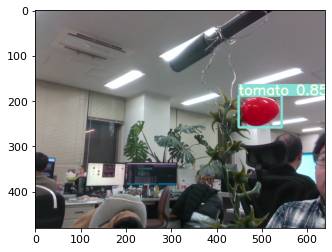

short_axis_angle: 174.92039489746094
Index:0, Pixel: (497, 223) -> Point: [-0.26899999380111694, 0.07399208843708038, -0.00626005046069622, 174]
关节 4 的变换: [[    0.21466     0.66066     0.71934    0.061988]
 [   -0.22229    -0.68413     0.69466   -0.064042]
 [    0.95106    -0.30902 -3.6732e-06     0.22181]
 [          0           0           0           1]],
坐标:[   0.061988   -0.064042     0.22181]
摄像头的位置（相对于世界坐标系）： [  0.0093544   -0.052725     0.27839]
Position of the most confident object to be tomato : [   -0.11379     0.18131     0.36747]
[   -0.11379     0.18131     0.36485]
target coor: [   -0.11379     0.18131     0.36485]
servos should be [     32.121      59.932      75.698      92.244]
The angles of each joints should be: [32, 59, 75, 92, 174.0, 80]
Error:0.18%
The position is:
 [[    0.84693    -0.39436    -0.35665    -0.11317]
 [    0.53171     0.62814     0.56808     0.18033]
 [-9.4888e-07    -0.67076     0.74167     0.36347]
 [          0           0           0          

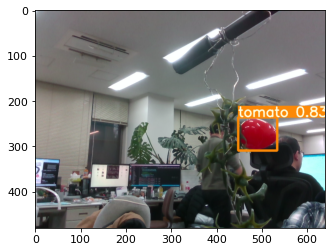

short_axis_angle: 180.0
Index:0, Pixel: (491, 272) -> Point: [-0.2619999945163727, 0.06952784955501556, 0.014628537930548191, 180]
关节 4 的变换: [[    0.23021     0.66858     0.70711    0.061674]
 [   -0.23021    -0.66858     0.70711   -0.061532]
 [    0.94552    -0.32557 -3.6732e-06     0.22335]
 [          0           0           0           1]],
坐标:[   0.061674   -0.061532     0.22335]
摄像头的位置（相对于世界坐标系）： [  0.0095542   -0.051838      0.2807]
Position of the most confident object to be tomato : [   -0.11982     0.17586     0.35217]
[   -0.11982     0.17586     0.35184]
target coor: [   -0.11982     0.17586     0.35184]
servos should be [     34.275      73.864      61.851      83.007]
The angles of each joints should be: [34, 73, 61, 83, 180.0, 80]
Error:0.00%
The position is:
 [[    0.82635    -0.35228    -0.43937    -0.11982]
 [    0.56316     0.51691     0.64471     0.17586]
 [-1.3755e-06    -0.78019     0.62554     0.35184]
 [          0           0           0           1]]
[34, 73, 

KeyboardInterrupt: 

In [166]:

task_list = [[-0.05,0.05,0.28],[-0.05,0.05,0.23],[-0.05,0.05,0.17]] # !!!!!!modify here to set the origin position
while task_list:
    target = task_list[0]
    s_time,target_joint_degree_list = control_arm_coor(Arm,my_chain,target,GRABBER['open'])
    time.sleep(1)
    flag = True

    det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,align,names)

    while det is not None and flag :
        flag = False
        position_tomato,rotation = object_position(det,aligned_depth_frame,depth_intrinsics)
        if position_tomato is not None:
            print(position_tomato)
            if control_arm_coor(Arm,my_chain,position_tomato,GRABBER['open'],rotation):
                control_arm_coor(Arm,my_chain,position_tomato,GRABBER['close'],rotation)
                control_arm_coor(Arm,my_chain,target,GRABBER['close'])
                control_arm_coor(Arm,my_chain,DROP_POSITION,GRABBER['close'])
                control_arm_coor(Arm,my_chain,DROP_POSITION,GRABBER['open'])
                control_arm_coor(Arm,my_chain,target,GRABBER['open'])
                flag = True
        time.sleep(1)
        det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,align,names)



    print(f"Task on {task_list.pop(0)} is finished")



# Below for debug

Done. (0.521s)
[tensor(413.12500, device='cuda:0', grad_fn=<SelectBackward>), tensor(285.01562, device='cuda:0', grad_fn=<SelectBackward>), tensor(438.87500, device='cuda:0', grad_fn=<SelectBackward>), tensor(317.48438, device='cuda:0', grad_fn=<SelectBackward>)]
[tensor(365.21875, device='cuda:0', grad_fn=<SelectBackward>), tensor(300.84375, device='cuda:0', grad_fn=<SelectBackward>), tensor(442.28125, device='cuda:0', grad_fn=<SelectBackward>), tensor(385.15625, device='cuda:0', grad_fn=<SelectBackward>)]


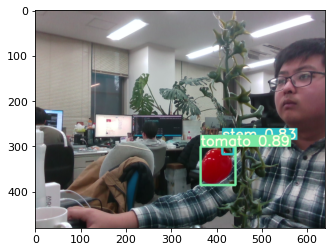

tensor([[365.21875, 300.84375, 442.28125, 385.15625,   0.88666,   1.00000],
        [413.12500, 285.01562, 438.87500, 317.48438,   0.83374,   0.00000]], device='cuda:0', grad_fn=<IndexBackward>) <pyrealsense2.frame Z16 #270139> [ 640x480  p[326.683 237.415]  f[619.191 619.425]  Inverse Brown Conrady [0 0 0 0 0] ]


In [155]:
frames = pipeline.wait_for_frames()
aligned_frames = align.process(frames)
aligned_depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()
# 将帧转换为numpy数组
color_image = np.asanyarray(color_frame.get_data())
color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
depth_intrinsics = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
device = torch.device('cuda:0')

img = torch.tensor(color_image)
img = np.transpose(img, (2, 0, 1))
half = device.type != 'cpu'  # half precision only supported on CUDA
img = img.half() if half else img.float()  # uint8 to fp16/32
img /= 255.0  # 0 - 255 to 0.0 - 1.0
if img.ndimension() == 3:
    img = img.unsqueeze(0)

img = img.to(device)
t1 = time_synchronized()
pred = model(img, augment=True)[0]

# Apply NMS
pred = non_max_suppression(pred, 0.81, 0.3, classes=None, agnostic=True)
t2 = time_synchronized()

# Process detections
img = np.array(img.squeeze(0).cpu())
img = np.transpose(img, (1, 2, 0))
img = img * 255
img = img.astype(np.uint8)
for i, det in enumerate(pred):  # detections per image
    # Print time (inference + NMS)
    print('Done. ({:.3f}s)'.format((t2 - t1)))    
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if det is not None:
    for *xyxy, conf, cls in reversed(det):
        label = '%s %.2f' % (names[int(cls)], conf)
        print(xyxy)
        plot_one_box(xyxy, img, label=label, line_thickness=3)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.show()

print(det,aligned_depth_frame,depth_intrinsics)

In [156]:
det
res = calculate_frame_coor(det)
det
*xyxy, conf, cls = det[0]
xyxy = [int(x) for x in xyxy]
xyxy

[365, 300, 442, 385]

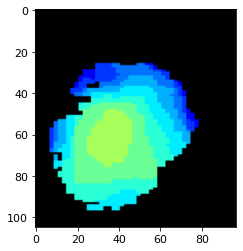

In [162]:
padding = 10
depth_image = np.asanyarray(aligned_depth_frame.get_data())
obj_depth_image = depth_image[(xyxy[1]-padding):(xyxy[3]+padding),(xyxy[0]-padding):(xyxy[2]+padding)]
hist, bin_edges = np.histogram(obj_depth_image,120,range=(100,600))
min_val = bin_edges[np.argmax(hist)-2]
max_val = bin_edges[np.argmax(hist)+2]
mask = (obj_depth_image > min_val) & (obj_depth_image < max_val)

normalized = np.zeros_like(obj_depth_image, dtype=np.uint8)
normalized[mask] = np.clip(obj_depth_image[mask], min_val, max_val) - min_val

normalized = ((obj_depth_image / (max_val - min_val)) * 255).astype(np.uint8)
depth_colormap = cv2.applyColorMap(normalized, cv2.COLORMAP_JET)
depth_colormap[~mask] = [0, 0, 0]  # 将原始零值位置设为黑色
plt.imshow(depth_colormap)


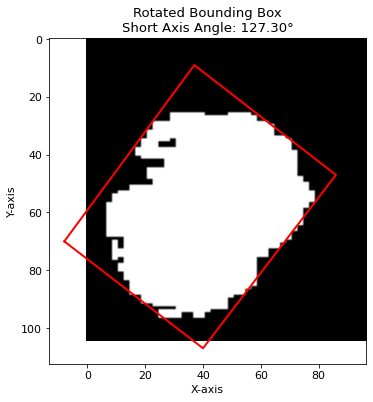

短轴的倾斜角：127.30°


In [163]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 找到 mask 中为 True 的坐标
y_coords, x_coords = np.where(mask)
points = np.column_stack((x_coords, y_coords))  # 转换为点集

# 计算旋转最小包围矩形
rect = cv2.minAreaRect(points.astype(np.float32))  # (center, (width, height), angle)
box = cv2.boxPoints(rect)  # 获取矩形顶点
box = np.int0(box)  # 转换为整数

# 提取矩形参数
(center_x, center_y), (width, height), angle = rect

# 短轴的倾斜角计算
if width < height:
    short_axis_angle = (angle + 90)  # 宽是短轴，直接取 angle
else:
    short_axis_angle = angle  # 高是短轴，角度加 90°

# 绘制原始图像和旋转矩形
plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap="gray", origin="upper")  # 显示原始 mask
plt.plot(
    *np.append(box, [box[0]], axis=0).T,  # 确保闭合
    color="red",
    linewidth=2,
)  # 绘制旋转矩形
plt.title(f"Rotated Bounding Box\nShort Axis Angle: {short_axis_angle:.2f}°")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(False)
plt.show()

# 输出短轴的倾斜角
print(f"短轴的倾斜角：{short_axis_angle:.2f}°")


In [ ]:
import ikpy.chain
from Arm_Lib import Arm_Device
Arm = Arm_Device()
my_chain = ikpy.chain.Chain.from_urdf_file("/home/jetson/code/yolov5/yolov5-3.0/arm_real.URDF")
degree_list = [0,180,130,40,20,90,30]
servo_write(Arm,degree_list[1:],SERVO_SPEED,s_time = 1500)
angle_test = np.radians(degree_list)
transformations = my_chain.forward_kinematics(angle_test, full_kinematics=True)
for i in range(1, len(transformations)):  # 忽略起点（索引0）
    print(f"关节 {i} 的位置: {transformations[i][:3, 3]}")

In [ ]:
transformations = my_chain.forward_kinematics(angle_test, full_kinematics=True)
for i in range(1, len(transformations)):  # 忽略起点（索引0）
    print(f"关节 {i} 的位置: {transformations[i][:3, 3]}")
angle_test = np.radians([0,90,130,30,0,90,30])
print(transformations[-1][:3,3])
joint_list = list(my_chain.inverse_kinematics(transformations[-1][:3,3],initial_position=angle_test))

print(joint_list)
print([0,0,130,51,19,90,30])
print("solve",np.degrees(joint_list))
real_frame = my_chain.forward_kinematics(joint_list, full_kinematics=True)
for i in range(1, len(real_frame)):  # 忽略起点（索引0）
    print(f"关节 {i} 的位置: {real_frame[i][:3, 3]}")

In [ ]:
joint_list = list(my_chain.inverse_kinematics([-0.05,0,0.35],initial_position=angle_test))
print(np.degrees(joint_list))

In [ ]:
target_position = [-0.05,0,0.35]
grabber = 20
converted_position = np.array(target_position)
print("target coor:",converted_position)
joints = my_chain.inverse_kinematics(converted_position,initial_position = np.radians([0,90,130,20,40,90,30]))
joint_list = joints[1:-1]
print("servos should be",np.degrees(joint_list))
joint_deg_list = [int(x)for x in np.degrees(joint_list)]
joint_deg_list.append(grabber)
print("The angles of each joints should be:" , joint_deg_list)
real_frame = my_chain.forward_kinematics(joints)
error = np.abs(np.linalg.norm(list(real_frame[:3,3]),ord=2)-np.linalg.norm(converted_position,ord=2))
print("Error:{:.2f}%".format(error*100))
print("The position is:\n", real_frame)
if "{:.2f}%".format(error*100) != "0.00%":
    print("out of range")
else:
    servo_write(Arm,joint_deg_list,SERVO_SPEED)

model = detect()
names = ['stem','tomato']
det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,names)